# Data extraction and merging


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
import os
import pickle
import codecs
import re
from tqdm import tqdm_notebook as tqdm

#For tokenizing sentences
import nltk
nltk.download('punkt')
plt.style.use('seaborn-whitegrid')

# Cte
BASE_PATH = "../data/"

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/salhilamia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/var/folders/my/5lwd7z794l5ch10f821f_jkm0000gn/T/ipykernel_5447/3106827710.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [14]:
import numpy as np
import pandas as pd
import datetime as dt
import os
import codecs
import io
from lxml import etree
from dateutil.relativedelta import *

import seaborn as sns; sns.set(style="darkgrid")
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import re
import pickle
from tqdm.notebook import tqdm

import nltk

## utils

### Reading the data

Nous avons 6 fichiers CSV :
- Statements : YES available right after each FOMC meeting
- Meeting Minutes : No because available three weeks after each FOMC meeting
- Press Conference Transcripts : YES to check
- Meeting Transcripts : NO available five years after the meeting
- Speeches : A considerer ça peut être interessant
- Testimony : 'Semiannual Monetary Policy Report to the Congress'

In [304]:
market_data_df = pd.read_csv("../data/dataset/agglomerate/agglomerate_fill_with_range_v2.csv", index_col=0)
market_data_sentiment = pd.read_csv("../data/dataset/agglomerate/agglomerate_filled_sentiment.csv")


In [305]:
market_data_sentiment.columns

Index(['date', 'w.bcpi_BCPI_WEEKLY', 'w.bcne_BCPI_WEEKLY',
       'w.ener_BCPI_WEEKLY', 'w.mtls_BCPI_WEEKLY', 'w.fopr_BCPI_WEEKLY',
       'w.agri_BCPI_WEEKLY', 'w.fish_BCPI_WEEKLY', 'v39078_CA.-interest_rate',
       'v121820_U.S.-interest_rate', 'value_FRED_CPIAUCSL', 'value_FRED_DFF',
       'value_FRED_GDPC1', 'value_FRED_GDPPOT', 'value_FRED_HSN1F',
       'value_FRED_PAYEMS', 'value_FRED_PCEPILFE', 'value_FRED_RRSFS',
       'value_FRED_UNRATE', 'fxusdcad_FXUSDCAD_rsi', 'rsi_FXUSDCAD_rsi',
       'pmi_ISM_MAN_PMI', 'index_ISM_NONMAN_NMI', '1 mo_USTREASURY_YIELD',
       'canada_bank_sentiment_last_week', 'canada_bank_sentiment_last_2week',
       'canada_bank_sentiment_last_month',
       'fomc_statement_sentiment_last_week',
       'fomc_statement_sentiment_last_2week',
       'fomc_statement_sentiment_last_month',
       'fomc_meeting_sentiment_last_week', 'fomc_meeting_sentiment_last_2week',
       'fomc_meeting_sentiment_last_month', 'fomc_minutes_sentiment_last_week',
      

In [306]:
market_data_df["fomc_statement_sentiment_last_week"] = market_data_sentiment["fomc_statement_sentiment_last_week"]
market_data_df["canada_bank_sentiment_last_week"] = market_data_sentiment["canada_bank_sentiment_last_week"]
market_data_df["fomc_presconf_sentiment_last_week"] = market_data_sentiment["fomc_presconf_sentiment_last_week"]
market_data_df["fomc_minutes_sentiment_last_week"] = market_data_sentiment["fomc_minutes_sentiment_last_week"]
market_data_df["fomc_testimony_sentiment_last_week"] = market_data_sentiment["fomc_testimony_sentiment_last_week"]
market_data_df.head()

,date,w.bcpi_BCPI_WEEKLY,w.bcne_BCPI_WEEKLY,w.ener_BCPI_WEEKLY,w.mtls_BCPI_WEEKLY,w.fopr_BCPI_WEEKLY,w.agri_BCPI_WEEKLY,w.fish_BCPI_WEEKLY,v39078_CA.-interest_rate,v121820_U.S.-interest_rate,...,fxusdcad_FXUSDCAD_rsi,rsi_FXUSDCAD_rsi,pmi_ISM_MAN_PMI,index_ISM_NONMAN_NMI,1 mo_USTREASURY_YIELD,fomc_statement_sentiment_last_week,canada_bank_sentiment_last_week,fomc_presconf_sentiment_last_week,fomc_minutes_sentiment_last_week,fomc_testimony_sentiment_last_week
0,2017-01-04,393.770000,303.210000,951.910000,488.660000,356.420000,207.020000,1293.840000,0.75,3.75,...,1.331500,41.796141,57.6,57.4,0.49,0.011111,0.014098,0.001223,0.002055,0.007442
1,2017-01-05,393.902857,303.647143,951.261429,489.705714,356.127143,207.402857,1298.995714,0.75,3.75,...,1.324400,41.796141,57.6,57.4,0.51,0.022222,0.028195,0.002446,0.004110,0.014884
2,2017-01-06,394.035714,304.084286,950.612857,490.751429,355.834286,207.785714,1304.151429,0.75,3.75,...,1.321400,41.796141,57.6,57.4,0.50,0.033333,0.042293,0.003669,0.006164,0.022326
3,2017-01-07,394.168571,304.521429,949.964286,491.797143,355.541429,208.168571,1309.307143,0.75,3.75,...,1.322267,41.796141,57.6,57.4,0.50,0.044444,0.056391,0.004892,0.008219,0.029767
4,2017-01-08,394.301429,304.958571,949.315714,492.842857,355.248571,208.551429,1314.462857,0.75,3.75,...,1.323133,41.796141,57.6,57.4,0.50,0.055556,0.070489,0.006115,0.010274,0.037209


## Evaluation

In [307]:
# fill nanq of market_data_df

In [308]:
import pandas as pd
from sklearn.metrics import mean_squared_error

def evaluate(pred_df: pd.DataFrame, test_path_csv: str) -> float:
    # Open test data
    test_df = pd.read_csv(test_path_csv)

    # Format data
    test_df['date'] = pd.to_datetime(test_df['date'], format='%Y-%m-%d')
    pred_df['date'] = pd.to_datetime(pred_df['date'], format='%Y-%m-%d')

    # Inner joint dataframe
    test_pred = test_df.merge(pred_df, on="date", how="inner")
    
    # Extract y true and y pred
    y_true = test_pred.FXUSDCAD_x.to_numpy()
    y_pred = test_pred.FXUSDCAD_y.to_numpy()

    mse = mean_squared_error(y_true, y_pred)
    print(f" Mean squared error: {mse}")

    # TODO: Add other metrics

    return mse

## remarks

Remarque sur les textes : 
- supprimer "[SECTION]", les "\n", les lists de nom de personnes du style "Jerome H. Powell, Chair; John C. Williams, Vice Chair; Michael S. Barr;"


List des mots redondants à supprimer (à plots):
- Committee
- les dates
- le début des textes

## baseline model XGboost and Logistic regression with the features selected

In [309]:
df2 = market_data_df.corr()

In [310]:
import seaborn as sns
%matplotlib inline
sns.set(rc={'figure.figsize':(13,13)})
#df2 = df2.drop(market_data_df.columns[-11:]).drop(market_data_df.columns[-11:], axis=1)
#df2= df2.drop(market_data_df.columns[12]).drop(df_market_features.columns[12], axis=1)
#df2 = df2.drop(market_data_df.columns[13]).drop(df_market_features.columns[13], axis=1)

<AxesSubplot:title={'center':'Correlation between market data'}>

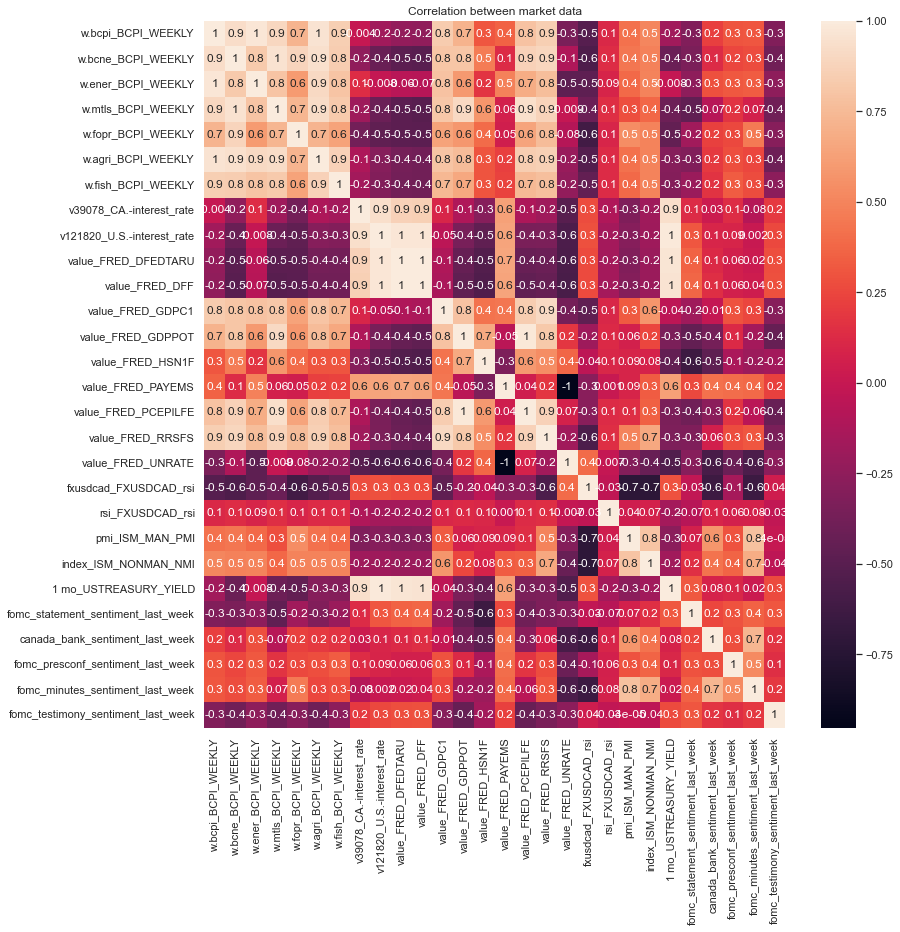

In [311]:
plt.title("Correlation between market data")
sns.heatmap(df2, annot=True, fmt=".1g")

## split train_test set

In [312]:
import pandas as pd
BASE_PATH = "../data"
def split_and_save(df: pd.DataFrame, date_split='2022-05-01', filename_prefix=None, output_path='', keep_index=False):
    """ Simple function to split data set """
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

    # Split data
    """ Train data """
    train = df.loc[(df['date'] < date_split)]
    """ Test data """
    test = df.loc[(df['date'] >= date_split)]

    # Save Value
    if filename_prefix != None:
        train.to_csv(f"{BASE_PATH}/train/{output_path}/{filename_prefix}.csv", index=keep_index)
        test.to_csv(f"{BASE_PATH}/test/{output_path}/{filename_prefix}.csv", index=keep_index)
    
    return train, test


In [313]:
train, test = split_and_save(market_data_df,filename_prefix="dataset", output_path="version1")

## x and y split

In [314]:
test.columns

Index(['date', 'w.bcpi_BCPI_WEEKLY', 'w.bcne_BCPI_WEEKLY',
       'w.ener_BCPI_WEEKLY', 'w.mtls_BCPI_WEEKLY', 'w.fopr_BCPI_WEEKLY',
       'w.agri_BCPI_WEEKLY', 'w.fish_BCPI_WEEKLY', 'v39078_CA.-interest_rate',
       'v121820_U.S.-interest_rate', 'value_FRED_DFEDTARU', 'value_FRED_DFF',
       'value_FRED_GDPC1', 'value_FRED_GDPPOT', 'value_FRED_HSN1F',
       'value_FRED_PAYEMS', 'value_FRED_PCEPILFE', 'value_FRED_RRSFS',
       'value_FRED_UNRATE', 'fxusdcad_FXUSDCAD_rsi', 'rsi_FXUSDCAD_rsi',
       'pmi_ISM_MAN_PMI', 'index_ISM_NONMAN_NMI', '1 mo_USTREASURY_YIELD',
       'fomc_statement_sentiment_last_week', 'canada_bank_sentiment_last_week',
       'fomc_presconf_sentiment_last_week', 'fomc_minutes_sentiment_last_week',
       'fomc_testimony_sentiment_last_week'],
      dtype='object')

In [315]:
X_train,y_train = train.drop(['fxusdcad_FXUSDCAD_rsi','date'], axis=1).to_numpy(),train['fxusdcad_FXUSDCAD_rsi'].values
X_test, y_test = test.drop(['fxusdcad_FXUSDCAD_rsi','date'], axis=1).to_numpy(),test['fxusdcad_FXUSDCAD_rsi'].values

In [316]:
X_train

array([[ 3.93770000e+02,  3.03210000e+02,  9.51910000e+02, ...,
         1.22292103e-03,  2.05479452e-03,  7.44186047e-03],
       [ 3.93902857e+02,  3.03647143e+02,  9.51261429e+02, ...,
         2.44584207e-03,  4.10958904e-03,  1.48837209e-02],
       [ 3.94035714e+02,  3.04084286e+02,  9.50612857e+02, ...,
         3.66876310e-03,  6.16438356e-03,  2.23255814e-02],
       ...,
       [ 8.47924286e+02,  5.81615714e+02,  2.01499000e+03, ...,
        -2.03961798e-02,  1.27688350e-02, -1.61936058e-01],
       [ 8.50488571e+02,  5.80701429e+02,  2.02710000e+03, ...,
        -2.05656875e-02,  1.30678579e-02, -1.67092587e-01],
       [ 8.53052857e+02,  5.79787143e+02,  2.03921000e+03, ...,
        -2.07351952e-02,  1.33668809e-02, -1.72249117e-01]])

## model simple XGboost

In [317]:
import xgboost
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
print(xgboost.__version__)

1.6.1


In [318]:
model = XGBRegressor(n_estimators=1000, max_depth=5, eta=0.1, subsample=0.7, colsample_bytree=0.8)

In [319]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(model, np.array(X_train), y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

In [320]:
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 0.003 (0.000)


In [321]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, ...)

In [322]:
y_test_pred  = model.predict(X_test)
y_train_pred = model.predict(X_train)

In [323]:
mean_squared_error(y_train, y_train_pred)

3.068533422686634e-07

In [324]:
mse = mean_squared_error(y_test, y_test_pred)
print(f" Mean squared error: {mse}")

 Mean squared error: 0.00197123432128861


### Random forest

In [346]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(max_depth=7, random_state=0, n_estimators=1000, criterion="absolute_error", min_samples_split=3)

In [347]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(model, np.array(X_train), y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

In [348]:
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 0.005 (0.000)


In [349]:
model.fit(X_train, y_train)

RandomForestRegressor(criterion='absolute_error', max_depth=7,
                      min_samples_split=3, n_estimators=1000, random_state=0)

In [350]:
y_test_pred  = model.predict(X_test)
y_train_pred = model.predict(X_train)

In [351]:
mean_squared_error(y_train, y_train_pred)

3.632104164784472e-05

In [352]:
mse = mean_squared_error(y_test, y_test_pred)
print(f" Mean squared error: {mse}")

 Mean squared error: 0.0011991289407629908


### Linear regression

In [366]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [367]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(model, np.array(X_train), y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

In [368]:
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 0.011 (0.000)


In [369]:
model.fit(X_train, y_train)

LinearRegression()

In [370]:
y_test_pred  = model.predict(X_test)
y_train_pred = model.predict(X_train)

In [371]:
mean_squared_error(y_train, y_train_pred)

0.0002016125559093239

In [372]:
mse = mean_squared_error(y_test, y_test_pred)
print(f" Mean squared error: {mse}")

 Mean squared error: 0.0015323278820382198


### SVR

In [404]:
from sklearn.svm import SVR
model = SVR(kernel="poly", coef0=1, C=1.0, epsilon=0.2)


In [405]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(model, np.array(X_train), y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

In [406]:
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 0.039 (0.001)


In [407]:
model.fit(X_train, y_train)

SVR(coef0=1, epsilon=0.2, kernel='poly')

In [408]:
y_test_pred  = model.predict(X_test)
y_train_pred = model.predict(X_train)

In [409]:
mean_squared_error(y_train, y_train_pred)

0.0024975395771430196

In [410]:
mse = mean_squared_error(y_test, y_test_pred)
print(f" Mean squared error: {mse}")

 Mean squared error: 0.0015700181535947704


### MLP Regressor

In [373]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [374]:
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [375]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(hidden_layer_sizes=(100, 1000, 100), random_state=1, max_iter=500)

In [376]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(model, np.array(X_train), y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

In [377]:
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 0.013 (0.001)


In [378]:
model.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(100, 1000, 100), max_iter=500, random_state=1)

In [379]:
y_test_pred  = model.predict(X_test)
y_train_pred = model.predict(X_train)

In [380]:
mean_squared_error(y_train, y_train_pred)

0.00020160803927733509

In [381]:
mse = mean_squared_error(y_test, y_test_pred)
print(f" Mean squared error: {mse}")

 Mean squared error: 0.01442907719648256


In [382]:
y_test_pred

array([1.26216875, 1.26112242, 1.25827837, 1.26166482, 1.25090753,
       1.24827814, 1.24487151, 1.24315293, 1.2419868 , 1.24269251,
       1.24226728, 1.23939021, 1.2394366 , 1.24094275, 1.24304338,
       1.24556422, 1.24860201, 1.25475427, 1.25751332, 1.26641548,
       1.2743197 , 1.28200765, 1.29067296, 1.29994199, 1.30570204,
       1.31144747, 1.31771768, 1.32180616, 1.32693739, 1.33225018,
       1.34425663, 1.34328939, 1.41472693, 1.40014022, 1.38884759,
       1.37723392, 1.36683242, 1.3531849 , 1.33731169, 1.32776005,
       1.31198132, 1.3087709 , 1.30461862, 1.30140113, 1.30179405,
       1.29741138, 1.29774413, 1.29789193, 1.29185412, 1.28893742,
       1.287356  , 1.26941855, 1.2573576 , 1.23906391, 1.22304703,
       1.21296382, 1.20278749, 1.19339288, 1.1812402 , 1.17642236,
       1.15420426, 1.14340032, 1.13293281, 1.12303936, 1.11449809,
       1.10730493, 1.11722608, 1.09741932, 1.08235751, 1.07412437,
       1.06624355, 1.05814127, 1.05072995, 1.04222983, 1.12210

## model simple XGboost

In [46]:
y_test_pred

array([1.2781255, 1.2776841, 1.2662358, 1.2639917, 1.2590585, 1.2580948,
       1.2600242, 1.2608554, 1.2615436, 1.2626987, 1.2625386, 1.2659221,
       1.2667046, 1.2665533, 1.2661642, 1.2657531, 1.2653742, 1.2663273,
       1.2662605, 1.2652539, 1.26209  , 1.2625262, 1.2627121, 1.2628597,
       1.2635956, 1.2635612, 1.2619236, 1.2619139, 1.261679 , 1.2609158,
       1.2575581, 1.2586015, 1.2553867, 1.2555594, 1.2550937, 1.2537807,
       1.2539724, 1.2534118, 1.2558354, 1.257765 , 1.2625991, 1.2614291,
       1.2613091, 1.2624462, 1.2623303, 1.2644268, 1.2621481, 1.2617985,
       1.2629579, 1.2629963, 1.262718 , 1.2630877, 1.2629763, 1.2710354,
       1.2697496, 1.2693689, 1.2690825, 1.2698426, 1.2696145, 1.2696567,
       1.269061 , 1.2690566, 1.2689534, 1.2683716, 1.2680404, 1.2660339,
       1.2683568, 1.2721806, 1.2718605, 1.2709477, 1.2703618, 1.270334 ,
       1.2711306, 1.2727451, 1.2722979, 1.2726022, 1.2724303, 1.2725768,
       1.2715645, 1.2709705, 1.2707486, 1.2699387, 

## 2.Data Cleaning

### 2.1.Remove punctuations

### 2.2 Word Replacement
### 2.3 Remove stopwords¶
### 2.4 Stemming/Lammetization - Tranforming any form of a word to its root word¶
### 2.5.a Stemming
### 2.5.b Lemmatization
### 2.6 plots